# Keras Backend

In this notebook we will be using the [Keras backend module](http://keras.io/backend/), which provides an abstraction over both Theano and Tensorflow.

Let's try to re-implement the Logistic Regression Model using the `keras.backend` APIs.

The following code will look like very similar to what we would write in Theano or Tensorflow (with the *only difference* that it may run on both the two backends).

In [1]:
import keras.backend as K
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

/home/reut/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from kaggle_data import load_data, preprocess_data, preprocess_labels

In [3]:
X_train, labels = load_data('data/kaggle_ottogroup/train.csv', train=True)
X_train, scaler = preprocess_data(X_train)
Y_train, encoder = preprocess_labels(labels)

X_test, ids = load_data('data/kaggle_ottogroup/test.csv', train=False)

X_test, _ = preprocess_data(X_test, scaler)

nb_classes = Y_train.shape[1]
print(nb_classes, 'classes')

dims = X_train.shape[1]
print(dims, 'features')

9 classes
93 features


In [4]:
feats = dims
training_steps = 25

In [5]:
x = K.placeholder(dtype="float", shape=X_train.shape) 
target = K.placeholder(dtype="float", shape=Y_train.shape)

# Set model weights
W = K.variable(np.random.rand(dims, nb_classes))
b = K.variable(np.random.rand(nb_classes))

In [6]:
# Define model and loss
y = K.dot(x, W) + b
loss = K.categorical_crossentropy(y, target)

In [7]:
activation = K.softmax(y) # Softmax

In [8]:
lr = K.constant(0.01)
grads = K.gradients(loss, [W,b])
updates = [(W, W-lr*grads[0]), (b, b-lr*grads[1])]

In [9]:
train = K.function(inputs=[x, target], outputs=[loss], updates=updates)

In [10]:
# Training
loss_history = []
for epoch in range(training_steps):
    current_loss = train([X_train, Y_train])[0]
    loss_history.append(current_loss)
    if epoch % 20 == 0:
        print("Loss: {}".format(current_loss))

Loss: [-260.18237  471.29474 2464.0732  ... -900.1108  -631.66    1810.8842 ]
Loss: [-29387892. -30627796. -31773536. ... -23432018. -22977790. -25626348.]


In [11]:
loss_history = [np.mean(lh) for lh in loss_history]

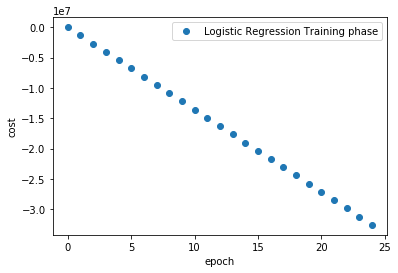

In [12]:
# plotting
plt.plot(range(len(loss_history)), loss_history, 'o', label='Logistic Regression Training phase')
plt.ylabel('cost')
plt.xlabel('epoch')
plt.legend()
plt.show()

## Your Turn

Please switch to the **Theano** backend and **restart** the notebook.

You _should_ see no difference in the execution!

**Reminder**: please keep in mind that you *can* execute shell commands from a notebook (pre-pending a `!` sign).
Thus:

```shell
    !cat ~/.keras/keras.json
```
should show you the content of your keras configuration file.

### Moreover

Try to play a bit with the **learning reate** parameter to see how the loss history floats... 

---

## Exercise: Linear Regression
To get familiar with automatic differentiation, we start by learning a simple linear regression model using Stochastic Gradient Descent (SGD).

Recall that given a dataset $\{(x_i, y_i)\}_{i=0}^N$, with $x_i, y_i \in \mathbb{R}$, the objective of linear regression is to find two scalars $w$ and $b$ such that $y = w\cdot x + b$ fits the dataset. In this tutorial we will learn $w$ and $b$ using SGD and a Mean Square Error (MSE) loss:

$$\mathcal{l} = \frac{1}{N} \sum_{i=0}^N (w\cdot x_i + b - y_i)^2$$

Starting from random values, parameters $w$ and $b$ will be updated at each iteration via the following rule:

$$w_t = w_{t-1} - \eta \frac{\partial \mathcal{l}}{\partial w}$$
<br>
$$b_t = b_{t-1} - \eta \frac{\partial \mathcal{l}}{\partial b}$$

where $\eta$ is the learning rate.

**NOTE:** Recall that **linear regression** is indeed a **simple neuron** with a linear activation function!!

### Definition: Placeholders and Variables

First of all, we define the necessary variables and placeholders for our computational graph. Variables maintain state across executions of the computational graph, while placeholders are ways to feed the graph with external data.

For the linear regression example, we need three variables: `w`, `b`, and the learning rate for SGD, `lr`. 

Two placeholders `x` and `target` are created to store $x_i$ and $y_i$ values.

In [15]:
# Placeholders and variables
x = K.placeholder()
target = K.placeholder()
w = K.variable(np.random.rand())
b = K.variable(np.random.rand())

#### Notes:

In case you're wondering what's the difference between a **placeholder** and a **variable**, in short:

* Use `K.variable()` for trainable variables such as weights (`W`) and biases (`b`) for your model.
* Use `K.placeholder()` to feed actual data (e.g. training examples)

## Model definition
Now we can define the $y = w\cdot x + b$ relation as well as the MSE loss in the computational graph.

In [ ]:
# Define model and loss

In [16]:
# %load solutions/sol11.py
y = w * x + b
loss = K.mean(K.square(y-target))

Then, given the gradient of MSE wrt to `w` and `b`, we can define how we update the parameters via SGD:

In [18]:
# %load solutions/sol12.py
grads = K.gradients(loss, [w,b])
updates = [(w, w-lr*grads[0]), (b, b-lr*grads[1])]

The whole model can be encapsulated in a `function`, which takes as input `x` and `target`, returns the current loss value and updates its parameter according to `updates`.

In [19]:
train = K.function(inputs=[x, target], outputs=[loss], updates=updates)

## Training
Training is now just a matter of calling the `function` we have just defined. Each time `train` is called, indeed, `w` and `b` will be updated using the SGD rule.

Having generated some random training data, we will feed the `train` function for several epochs and observe the values of `w`, `b`, and loss.

In [20]:
# Generate data
np_x = np.random.rand(1000)
np_target = 0.96*np_x + 0.24

In [21]:
# Training
loss_history = []
for epoch in range(200):
    current_loss = train([np_x, np_target])[0]
    loss_history.append(current_loss)
    if epoch % 20 == 0:
        print("Loss: %.03f, w, b: [%.02f, %.02f]" % (current_loss, K.eval(w), K.eval(b)))

Loss: 0.261, w, b: [0.26, 0.13]
Loss: 0.105, w, b: [0.36, 0.28]
Loss: 0.049, w, b: [0.42, 0.36]
Loss: 0.029, w, b: [0.46, 0.41]
Loss: 0.021, w, b: [0.49, 0.43]
Loss: 0.017, w, b: [0.51, 0.45]
Loss: 0.016, w, b: [0.53, 0.45]
Loss: 0.015, w, b: [0.54, 0.45]
Loss: 0.014, w, b: [0.55, 0.45]
Loss: 0.013, w, b: [0.57, 0.45]


We can also plot the loss history:

### Plot loss history

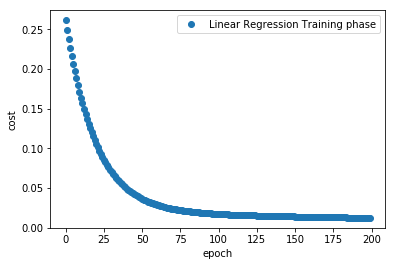

In [23]:
# %load solutions/sol13.py
plt.plot(range(len(loss_history)), loss_history, 'o', label='Linear Regression Training phase')
plt.ylabel('cost')
plt.xlabel('epoch')
plt.legend()
plt.show()

### Final Note:

Please switch back your backend to `tensorflow` before moving on. It may be useful for next notebooks !-)